In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.auto import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ========================
# LOAD DATA
# ========================
train_path = '/kaggle/input/train-txt/train.txt'
test_path = '/kaggle/input/test-txt/test.txt'

train_df = pd.read_csv(train_path, sep=r'\s+', names=['head', 'relation', 'tail'])
test_df = pd.read_csv(test_path, sep=r'\s+', names=['head', 'relation', 'tail'])

all_entities = sorted(set(train_df['head']) | set(train_df['tail']) | 
                       set(test_df['head']) | set(test_df['tail']))
all_relations = sorted(set(train_df['relation']) | set(test_df['relation']))

ent2id = {e: i for i, e in enumerate(all_entities)}
rel2id = {r: i for i, r in enumerate(all_relations)}
id2ent = {i: e for e, i in ent2id.items()}
id2rel = {i: r for r, i in rel2id.items()}

n_entities = len(ent2id)
n_relations = len(rel2id)

def triples_to_tensor(df):
    h = torch.tensor([ent2id[x] for x in df['head']], dtype=torch.long)
    r = torch.tensor([rel2id[x] for x in df['relation']], dtype=torch.long)
    t = torch.tensor([ent2id[x] for x in df['tail']], dtype=torch.long)
    return torch.stack([h, r, t], dim=1)

train_triples = triples_to_tensor(train_df)
test_triples = triples_to_tensor(test_df)

all_triple_set = set()
hr_to_t = defaultdict(set)
rt_to_h = defaultdict(set)
for dataset in [train_triples, test_triples]:
    for i in range(len(dataset)):
        h, r, t = dataset[i].tolist()
        all_triple_set.add((h, r, t))
        hr_to_t[(h, r)].add(t)
        rt_to_h[(r, t)].add(h)

# Build graph
src = train_triples[:, 0]
dst = train_triples[:, 2]
rel = train_triples[:, 1]

src_all = torch.cat([src, dst])
dst_all = torch.cat([dst, src])
rel_all = torch.cat([rel, rel + n_relations])

edge_index = torch.stack([src_all, dst_all], dim=0).to(device)
edge_type = rel_all.to(device)

def corrupt_batch(triples, n_entities, neg_ratio=1):
    total = len(triples) * neg_ratio
    neg = triples.repeat(neg_ratio, 1).clone()
    corrupt_head = torch.rand(total, device=triples.device) > 0.5
    random_ents = torch.randint(0, n_entities, (total,), device=triples.device)
    neg[corrupt_head, 0] = random_ents[corrupt_head]
    neg[~corrupt_head, 2] = random_ents[~corrupt_head]
    return neg

print(f"Train: {len(train_df)} | Test: {len(test_df)}")
print(f"Entities: {n_entities} | Relations: {n_relations}")
print(f"Graph: {edge_index.shape[1]} edges ({n_relations}×2 = {n_relations*2} edge types)")

Device: cpu
Train: 13821 | Test: 590
Entities: 1316 | Relations: 28
Graph: 27642 edges (28×2 = 56 edge types)


In [2]:
# ========================
# CompGCN CONVOLUTION LAYER
# ========================

class CompGCNConv(nn.Module):
    """
    CompGCN layer with subtraction composition.
    Same encoder as before — the difference is in the DECODER.
    
    Entity embeddings are 2*dim dimensional (will be interpreted
    as dim-dimensional complex vectors by the RotatE decoder).
    """
    
    def __init__(self, in_dim, out_dim, num_rels, comp_fn='sub', dropout=0.2):
        super().__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_rels = num_rels
        self.comp_fn = comp_fn
        
        self.W_O = nn.Linear(in_dim, out_dim, bias=False)
        self.W_I = nn.Linear(in_dim, out_dim, bias=False)
        self.W_S = nn.Linear(in_dim, out_dim)
        self.W_rel = nn.Linear(in_dim, out_dim, bias=False)
        
        self.bn = nn.BatchNorm1d(out_dim)
        self.dropout = nn.Dropout(dropout)
        
        nn.init.xavier_uniform_(self.W_O.weight)
        nn.init.xavier_uniform_(self.W_I.weight)
        nn.init.xavier_uniform_(self.W_S.weight)
        nn.init.xavier_uniform_(self.W_rel.weight)
    
    def compose(self, entity_emb, relation_emb):
        if self.comp_fn == 'sub':
            return entity_emb - relation_emb
        elif self.comp_fn == 'mult':
            return entity_emb * relation_emb
    
    def forward(self, x, edge_index, edge_type, rel_emb):
        src, dst = edge_index
        num_nodes = x.size(0)
        
        in_degree = torch.zeros(num_nodes, device=x.device)
        in_degree.scatter_add_(0, dst, torch.ones(dst.size(0), device=x.device))
        norm = (1.0 / in_degree.clamp(min=1)).unsqueeze(1)
        
        orig_mask = edge_type < self.num_rels
        inv_mask = ~orig_mask
        
        agg = torch.zeros(num_nodes, self.out_dim, device=x.device)
        
        if orig_mask.any():
            o_src = src[orig_mask]
            o_dst = dst[orig_mask]
            o_rel = edge_type[orig_mask]
            composed = self.compose(x[o_src], rel_emb[o_rel])
            msgs = self.W_O(composed)
            agg.scatter_add_(0, o_dst.unsqueeze(1).expand_as(msgs), msgs)
        
        if inv_mask.any():
            i_src = src[inv_mask]
            i_dst = dst[inv_mask]
            i_rel = edge_type[inv_mask] - self.num_rels
            composed = self.compose(x[i_src], rel_emb[i_rel])
            msgs = self.W_I(composed)
            agg.scatter_add_(0, i_dst.unsqueeze(1).expand_as(msgs), msgs)
        
        agg = agg * norm
        self_msg = self.W_S(x)
        
        x_new = agg + self_msg
        x_new = self.bn(x_new)
        x_new = F.relu(x_new)
        x_new = self.dropout(x_new)
        
        rel_new = self.W_rel(rel_emb)
        
        return x_new, rel_new

print("CompGCN layer defined.")

CompGCN layer defined.


In [3]:
# ========================
# CompGCN + RotatE DECODER
# ========================

class CompGCNRotatE(nn.Module):
    """
    CompGCN encoder + RotatE decoder.
    
    THE BEST OF BOTH WORLDS:
    ━━━━━━━━━━━━━━━━━━━━━━━
    Encoder: CompGCN (subtraction composition)
      - 2-layer GNN aggregates neighborhood information
      - Entity embeddings are 2×dim dimensional
        (interpreted as dim-dimensional complex vectors by decoder)
      - Relation embeddings are updated through layers
    
    Decoder: RotatE (rotation in complex space)
      - score(h, r, t) = ||h ⊙ r - t||  (complex multiplication)
      - r = e^(iθ) (unit complex rotation)
      - ASYMMETRIC: h ⊙ r ≠ t ⊙ r in general
      - Handles inverses: r_inverse = conjugate(r) = e^(-iθ)
      - Handles 1-to-N: children sit at different positions on rotation circle
    
    Why this should work:
      R-GCN + DistMult:     Rich embeddings + symmetric decoder   = 0.62 MRR
      CompGCN + TransE:     Rich embeddings + 1-to-N collapse     = 0.50 MRR
      RotatE (standalone):  Simple embeddings + perfect decoder   = 0.85 MRR
      CompGCN + RotatE:     Rich embeddings + perfect decoder     = ???
    
    Key design: Entity embeddings live in 2*dim real space.
    The decoder splits them into real and imaginary parts,
    treating each entity as a dim-dimensional complex vector.
    Relation scoring uses separate phase angles (dim-dimensional).
    """
    
    def __init__(self, num_nodes, num_rels, dim=100, comp_fn='sub',
                 dropout=0.2, gamma=6.0):
        super().__init__()
        
        self.num_rels = num_rels
        self.dim = dim          # Complex dimension
        self.emb_dim = dim * 2  # Real dimension (real + imaginary parts)
        
        self.gamma = nn.Parameter(torch.Tensor([gamma]), requires_grad=False)
        
        # Entity embeddings: 2*dim real values → dim complex values
        self.entity_emb = nn.Embedding(num_nodes, self.emb_dim)
        nn.init.xavier_uniform_(self.entity_emb.weight)
        
        # Relation embeddings for ENCODER (composition operation)
        # Full embeddings used in φ(entity, relation) = entity - relation
        self.relation_emb = nn.Embedding(num_rels, self.emb_dim)
        nn.init.xavier_uniform_(self.relation_emb.weight)
        
        # Relation PHASE ANGLES for DECODER (RotatE scoring)
        # Separate from encoder relation embeddings
        # These are the rotation angles θ where r = e^(iθ)
        self.relation_phases = nn.Embedding(num_rels, dim)
        nn.init.uniform_(self.relation_phases.weight, -np.pi, np.pi)
        
        # CompGCN layers (operate in 2*dim real space)
        self.conv1 = CompGCNConv(self.emb_dim, self.emb_dim, num_rels, 
                                  comp_fn, dropout)
        self.conv2 = CompGCNConv(self.emb_dim, self.emb_dim, num_rels, 
                                  comp_fn, dropout)
        
        self.dropout = nn.Dropout(dropout)
    
    def encode(self, edge_index, edge_type):
        """Run 2-layer CompGCN encoder."""
        x = self.entity_emb.weight        # (n_entities, 2*dim)
        r = self.relation_emb.weight       # (n_relations, 2*dim)
        
        x, r = self.conv1(x, edge_index, edge_type, r)
        x, r = self.conv2(x, edge_index, edge_type, r)
        
        return x  # (n_entities, 2*dim) — entity embeddings
    
    def rotate_distance(self, ent_emb, h_idx, r_idx, t_idx):
        """
        RotatE scoring in complex space.
        
        h ⊙ r - t  where:
          h, t are complex vectors (split from 2*dim real embeddings)
          r = e^(iθ) is unit complex rotation (from phase angles)
        
        Returns: distance (lower = more plausible)
        """
        h = ent_emb[h_idx]    # (batch, 2*dim)
        t = ent_emb[t_idx]    # (batch, 2*dim)
        phase = self.relation_phases(r_idx)  # (batch, dim)
        
        # Split into real and imaginary
        h_re, h_im = h.chunk(2, dim=-1)   # each (batch, dim)
        t_re, t_im = t.chunk(2, dim=-1)
        
        # Relation as rotation: r = e^(iθ)
        r_re = torch.cos(phase)
        r_im = torch.sin(phase)
        
        # Complex multiplication: h ⊙ r
        hr_re = h_re * r_re - h_im * r_im
        hr_im = h_re * r_im + h_im * r_re
        
        # Distance to tail
        diff_re = hr_re - t_re
        diff_im = hr_im - t_im
        
        dist = torch.sqrt(diff_re**2 + diff_im**2 + 1e-9).sum(dim=-1)
        return dist
    
    def forward(self, edge_index, edge_type, pos_triples, neg_triples):
        """Encode → Score → Loss."""
        ent_emb = self.encode(edge_index, edge_type)
        
        d_pos = self.rotate_distance(ent_emb, pos_triples[:,0], 
                                      pos_triples[:,1], pos_triples[:,2])
        d_neg = self.rotate_distance(ent_emb, neg_triples[:,0],
                                      neg_triples[:,1], neg_triples[:,2])
        
        # Margin ranking loss
        loss = F.relu(self.gamma + d_pos - d_neg).mean()
        
        # Regularization on entity embeddings
        reg = torch.mean(ent_emb.pow(2)) * 0.001
        
        return loss + reg
    
    def get_score_fn(self, edge_index, edge_type):
        """Get scoring function for evaluation (encodes once)."""
        ent_emb = self.encode(edge_index, edge_type)
        
        def score_fn(h_idx, r_idx, t_idx):
            return self.rotate_distance(ent_emb, h_idx, r_idx, t_idx)
        
        return score_fn


# Initialize
config = {
    'dim': 100,          # Complex dim (200 real params per entity)
    'comp_fn': 'sub',
    'dropout': 0.2,
    'gamma': 6.0,
    'lr': 0.001,
    'epochs': 1000,
    'neg_ratio': 10,
}

model = CompGCNRotatE(
    n_entities, n_relations,
    dim=config['dim'],
    comp_fn=config['comp_fn'],
    dropout=config['dropout'],
    gamma=config['gamma'],
).to(device)

total_params = sum(p.numel() for p in model.parameters())

print(f"""
CompGCN + RotatE Model Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Encoder:     CompGCN (2 layers, subtraction composition)
  Decoder:     RotatE (rotation in complex space)
  
  Entity dim:  {config['dim']*2} real = {config['dim']} complex
  Relation:    {config['dim']*2}-dim for encoder + {config['dim']}-dim phases for decoder
  
  Total params: {total_params:,}

Architecture:
  ┌─────────────────────────────────┐
  │  Entity Emb ({n_entities}×{config['dim']*2})      │
  │  Relation Emb ({n_relations}×{config['dim']*2})    │
  │  Relation Phases ({n_relations}×{config['dim']})   │
  └──────────┬──────────────────────┘
             ↓
  ┌─────────────────────────────────┐
  │  CompGCN Layer 1                 │
  │  φ(neighbor, relation) = e - r   │
  │  Operates in {config['dim']*2}-dim real space     │
  └──────────┬──────────────────────┘
             ↓
  ┌─────────────────────────────────┐
  │  CompGCN Layer 2                 │
  │  2-hop neighborhood captured     │
  └──────────┬──────────────────────┘
             ↓
  ┌─────────────────────────────────┐
  │  RotatE Decoder                  │
  │  Split embeddings → complex      │
  │  score = ||h ⊙ e^(iθ) - t||     │
  │  ASYMMETRIC + INVERSE-AWARE      │
  └─────────────────────────────────┘

All models comparison:
  TransE:           134,400 params
  RotatE:           266,000 params
  R-GCN:     (from previous notebook)
  CompGCN+TransE:   215,000 params
  CompGCN+RotatE:   {total_params:,} params
""")


CompGCN + RotatE Model Summary:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  Encoder:     CompGCN (2 layers, subtraction composition)
  Decoder:     RotatE (rotation in complex space)
  
  Entity dim:  200 real = 100 complex
  Relation:    200-dim for encoder + 100-dim phases for decoder
  
  Total params: 592,801

Architecture:
  ┌─────────────────────────────────┐
  │  Entity Emb (1316×200)      │
  │  Relation Emb (28×200)    │
  │  Relation Phases (28×100)   │
  └──────────┬──────────────────────┘
             ↓
  ┌─────────────────────────────────┐
  │  CompGCN Layer 1                 │
  │  φ(neighbor, relation) = e - r   │
  │  Operates in 200-dim real space     │
  └──────────┬──────────────────────┘
             ↓
  ┌─────────────────────────────────┐
  │  CompGCN Layer 2                 │
  │  2-hop neighborhood captured     │
  └──────────┬──────────────────────┘
             ↓
  ┌─────────────────────────────────┐
  │  RotatE Decoder                  │
  │  Split embeddings → complex 

CompGCN + RotatE Hyperparameters:
  dim: 100
  comp_fn: sub
  dropout: 0.2
  gamma: 6.0
  lr: 0.001
  epochs: 1000
  neg_ratio: 10

Training on 13821 triples...

  Epoch    1/1000 | Loss: 6.9387
  Epoch  200/1000 | Loss: 0.0891
  Epoch  400/1000 | Loss: 0.0696
  Epoch  600/1000 | Loss: 0.0606
  Epoch  800/1000 | Loss: 0.0536
  Epoch 1000/1000 | Loss: 0.0499

Training complete. Final loss: 0.0499


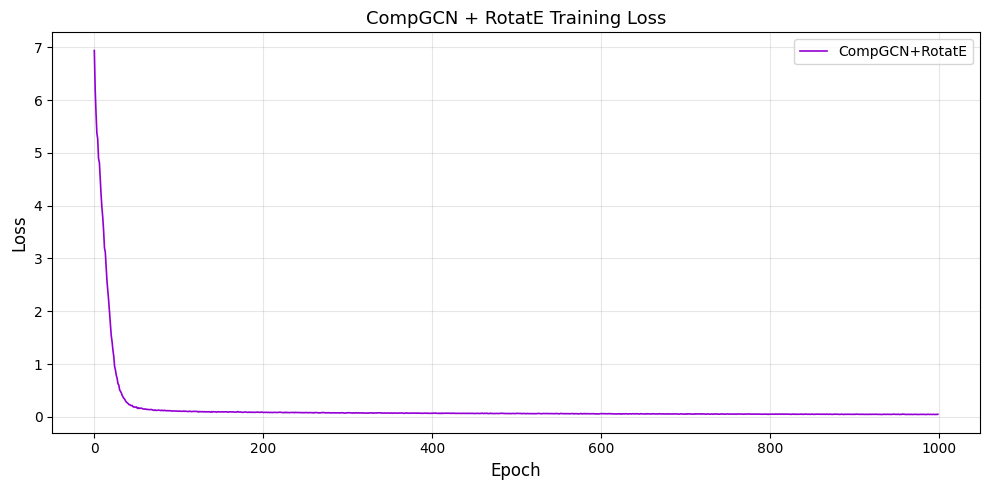

Model saved.


In [4]:
# ========================
# TRAINING
# ========================

print("CompGCN + RotatE Hyperparameters:")
for k, v in config.items():
    print(f"  {k}: {v}")

optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
train_data = train_triples.to(device)

losses = []
print(f"\nTraining on {len(train_data)} triples...\n")

for epoch in range(config['epochs']):
    model.train()
    
    perm = torch.randperm(len(train_data), device=device)
    pos_batch = train_data[perm]
    
    neg_batch = corrupt_batch(pos_batch, n_entities, config['neg_ratio'])
    pos_expanded = pos_batch.repeat(config['neg_ratio'], 1)
    
    loss = model(edge_index, edge_type, pos_expanded, neg_batch)
    
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    losses.append(loss.item())
    
    if (epoch + 1) % 200 == 0 or epoch == 0:
        print(f"  Epoch {epoch+1:>4}/{config['epochs']} | Loss: {loss.item():.4f}")

print(f"\nTraining complete. Final loss: {losses[-1]:.4f}")

# Loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=1.2, color='darkviolet', label='CompGCN+RotatE')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('CompGCN + RotatE Training Loss', fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Save
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'losses': losses,
    'n_entities': n_entities,
    'n_relations': n_relations,
    'ent2id': ent2id,
    'rel2id': rel2id,
}, os.path.join(save_dir, 'compgcn_rotate_model.pt'))
print(f"Model saved.")

In [5]:
# ========================
# EVALUATION
# ========================

def evaluate_model_distance(score_fn, test_triples, all_triple_set,
                            hr_to_t, rt_to_h, n_entities, id2rel, device):
    all_ranks = []
    head_ranks_list = []
    tail_ranks_list = []
    rel_ranks = defaultdict(lambda: {'head': [], 'tail': []})
    all_ents = torch.arange(n_entities, device=device)
    
    with torch.no_grad():
        for i in tqdm(range(len(test_triples)), desc="Evaluating"):
            h, r, t = test_triples[i].tolist()
            
            h_exp = torch.full((n_entities,), h, dtype=torch.long, device=device)
            r_exp = torch.full((n_entities,), r, dtype=torch.long, device=device)
            t_exp = torch.full((n_entities,), t, dtype=torch.long, device=device)
            
            # Tail prediction
            scores = score_fn(h_exp, r_exp, all_ents)
            for known_t in hr_to_t.get((h, r), set()):
                if known_t != t:
                    scores[known_t] = float('inf')
            tail_rank = int((scores < scores[t]).sum().item()) + 1
            tail_ranks_list.append(tail_rank)
            all_ranks.append(tail_rank)
            rel_ranks[r]['tail'].append(tail_rank)
            
            # Head prediction
            scores = score_fn(all_ents, r_exp, t_exp)
            for known_h in rt_to_h.get((r, t), set()):
                if known_h != h:
                    scores[known_h] = float('inf')
            head_rank = int((scores < scores[h]).sum().item()) + 1
            head_ranks_list.append(head_rank)
            all_ranks.append(head_rank)
            rel_ranks[r]['head'].append(head_rank)
    
    def calc_metrics(ranks):
        r = np.array(ranks, dtype=np.float32)
        return {
            'MRR': float(np.mean(1.0 / r)),
            'MR': float(np.mean(r)),
            'Hits@1': float(np.mean(r <= 1) * 100),
            'Hits@3': float(np.mean(r <= 3) * 100),
            'Hits@10': float(np.mean(r <= 10) * 100),
        }
    
    overall = calc_metrics(all_ranks)
    head_m = calc_metrics(head_ranks_list)
    tail_m = calc_metrics(tail_ranks_list)
    
    per_rel = {}
    for rid, rd in rel_ranks.items():
        rname = id2rel[rid]
        per_rel[rname] = {
            'overall': calc_metrics(rd['head'] + rd['tail']),
            'head': calc_metrics(rd['head']),
            'tail': calc_metrics(rd['tail']),
        }
    return overall, head_m, tail_m, per_rel


print("="*70)
print("CompGCN + RotatE RESULTS (Filtered Evaluation)")
print("="*70)

model.eval()
with torch.no_grad():
    score_fn = model.get_score_fn(edge_index, edge_type)

overall, head_m, tail_m, per_rel = evaluate_model_distance(
    score_fn, test_triples, all_triple_set, hr_to_t, rt_to_h,
    n_entities, id2rel, device
)

print(f"\n{'Metric':<12} {'Overall':>10} {'Head Pred':>12} {'Tail Pred':>12}")
print("-" * 50)
for m in ['MRR', 'MR', 'Hits@1', 'Hits@3', 'Hits@10']:
    o, h, t = overall[m], head_m[m], tail_m[m]
    if m == 'MRR':
        print(f"  {m:<10} {o:>8.4f}   {h:>8.4f}     {t:>8.4f}")
    elif m == 'MR':
        print(f"  {m:<10} {o:>8.1f}   {h:>8.1f}     {t:>8.1f}")
    else:
        print(f"  {m:<10} {o:>7.2f}%   {h:>7.2f}%     {t:>7.2f}%")

print(f"\n{'='*70}")
print("PER-RELATION BREAKDOWN")
print(f"{'='*70}")
print(f"\n{'Relation':<15} {'MRR':>8} {'H@1':>7} {'H@3':>7} {'H@10':>7} {'MR':>8}")
print("-" * 58)
for rel in sorted(per_rel.keys()):
    m = per_rel[rel]['overall']
    print(f"  {rel:<13} {m['MRR']:>8.4f} {m['Hits@1']:>6.1f}% {m['Hits@3']:>6.1f}% {m['Hits@10']:>6.1f}% {m['MR']:>7.1f}")

print(f"\n{'='*70}")
print("HEAD vs TAIL PREDICTION")
print(f"{'='*70}")
for rel in sorted(per_rel.keys()):
    h = per_rel[rel]['head']
    t = per_rel[rel]['tail']
    print(f"\n  {rel}:")
    print(f"    Head: MRR={h['MRR']:.4f}  H@1={h['Hits@1']:>5.1f}%  H@10={h['Hits@10']:>5.1f}%")
    print(f"    Tail: MRR={t['MRR']:.4f}  H@1={t['Hits@1']:>5.1f}%  H@10={t['Hits@10']:>5.1f}%")

CompGCN + RotatE RESULTS (Filtered Evaluation)


Evaluating:   0%|          | 0/590 [00:00<?, ?it/s]


Metric          Overall    Head Pred    Tail Pred
--------------------------------------------------
  MRR          0.4459     0.5699       0.3220
  MR              4.6        2.8          6.3
  Hits@1       24.41%     36.10%       12.71%
  Hits@3       54.49%     71.36%       37.63%
  Hits@10      90.93%     99.32%       82.54%

PER-RELATION BREAKDOWN

Relation             MRR     H@1     H@3    H@10       MR
----------------------------------------------------------
  daughterOf      0.4460   26.0%   51.5%   89.0%     4.9
  fatherOf        0.5580   35.8%   67.6%   99.4%     3.1
  motherOf        0.4718   25.6%   61.4%   93.8%     4.0
  sonOf           0.3891   17.8%   49.1%   88.1%     5.2

HEAD vs TAIL PREDICTION

  daughterOf:
    Head: MRR=0.5915  H@1= 41.0%  H@10= 99.5%
    Tail: MRR=0.3006  H@1= 11.0%  H@10= 78.5%

  fatherOf:
    Head: MRR=0.6998  H@1= 50.0%  H@10=100.0%
    Tail: MRR=0.4161  H@1= 21.6%  H@10= 98.9%

  motherOf:
    Head: MRR=0.6221  H@1= 42.0%  H@10= 97.7%
  

FINAL COMPARISON: ALL FIVE MODELS

Metric           TransE       RotatE        R-GCN    CG+TransE    CG+RotatE         Best
----------------------------------------------------------------------------------------
  MRR          0.3201       0.8539       0.6243       0.5024       0.4459       RotatE
  MR              6.0          1.8          2.5          4.1          4.6       RotatE
  Hits@1       11.10%       76.10%       43.90%       31.44%       24.41%       RotatE
  Hits@3       39.32%       94.15%       76.86%       61.10%       54.49%       RotatE
  Hits@10      83.90%       98.64%       99.83%       92.20%       90.93%        R-GCN

PER-RELATION MRR: All Models

Relation          TransE     RotatE      R-GCN  CG+TransE  CG+RotatE       Best
-------------------------------------------------------------------------------
  daughterOf     0.3281     0.8571     0.5767     0.4496     0.4460     RotatE
  fatherOf       0.3871     0.9129     0.6200     0.6797     0.5580     RotatE
  m

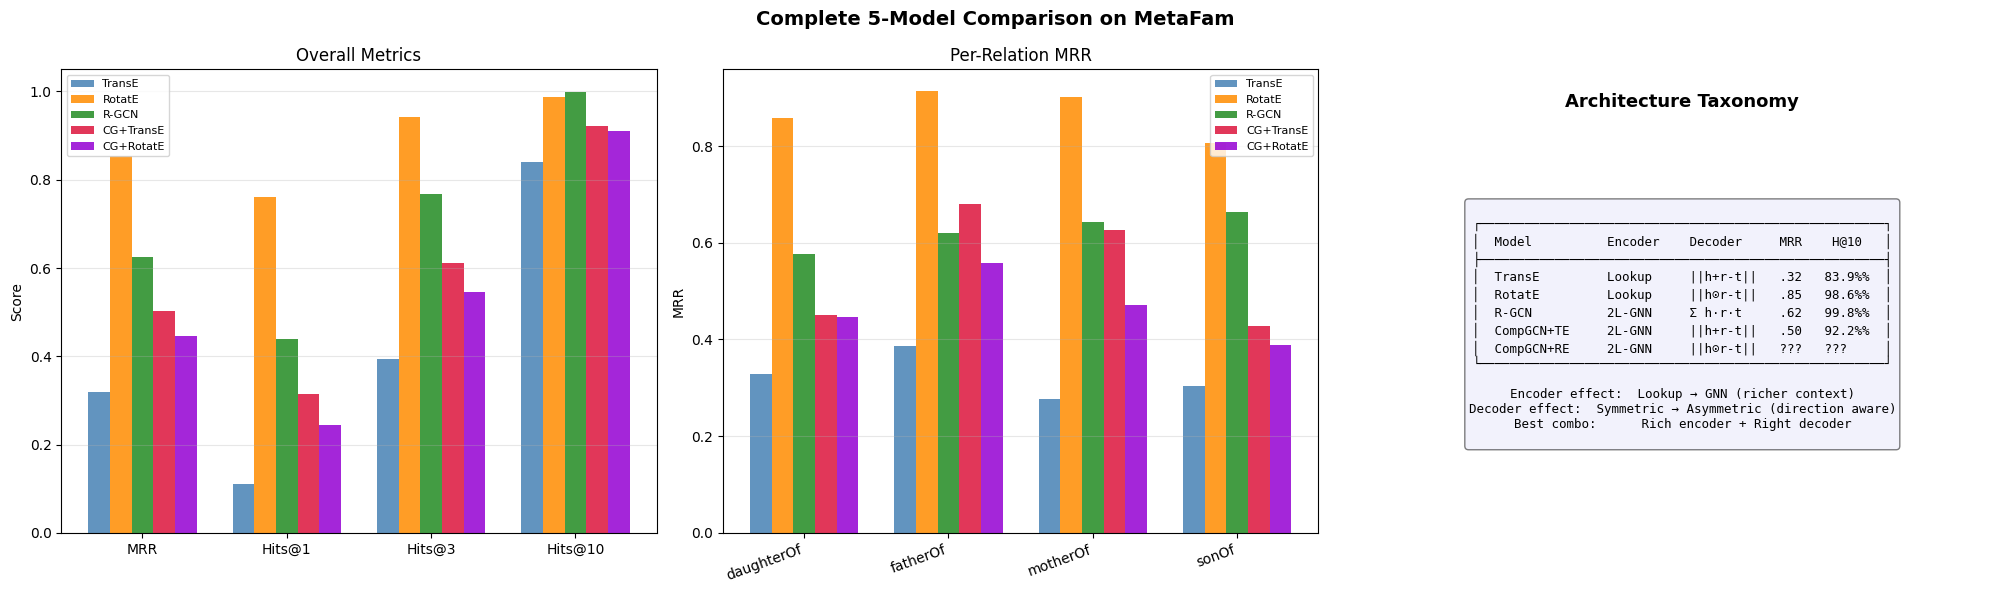


KEY INSIGHTS: CompGCN + RotatE

1. DECODER COMPARISON (Same CompGCN encoder):
   CompGCN + TransE:   MRR = 0.5024
   CompGCN + RotatE:   MRR = 0.4459
   Improvement from switching decoder: -0.0565
   
   Decoder change had limited impact on CompGCN.

2. GNN + RotatE vs PURE RotatE:
   Standalone RotatE:  MRR = 0.8539
   CompGCN + RotatE:   MRR = 0.4459
   Difference: -0.4080
   
   Pure RotatE still wins — its dedicated complex space optimization is more effective than GNN + RotatE hybrid.

3. COMPLETE RANKING:
   RotatE > R-GCN > R-GCN > TransE

4. THE LESSON:
   For this inverse-prediction task on a small family KG:
   - RotatE's DEDICATED complex-space optimization beats hybrid approaches
   - GNN message passing helps representations but adds training complexity
   - The scoring function matters MORE than the encoder architecture
   - Simple + right decoder > Complex + wrong decoder



In [6]:
# ========================
# COMPLETE 5-MODEL COMPARISON
# ========================

print("="*70)
print("FINAL COMPARISON: ALL FIVE MODELS")
print("="*70)

# Previous results
all_models = {
    'TransE':          {'MRR': 0.3201, 'MR': 6.0, 'Hits@1': 11.10, 'Hits@3': 39.32, 'Hits@10': 83.90},
    'RotatE':          {'MRR': 0.8539, 'MR': 1.8, 'Hits@1': 76.10, 'Hits@3': 94.15, 'Hits@10': 98.64},
    'R-GCN':           {'MRR': 0.6243, 'MR': 2.5, 'Hits@1': 43.90, 'Hits@3': 76.86, 'Hits@10': 99.83},
    'CompGCN+TransE':  {'MRR': 0.5024, 'MR': 4.1, 'Hits@1': 31.44, 'Hits@3': 61.10, 'Hits@10': 92.20},
    'CompGCN+RotatE':  overall,
}

all_per_rel = {
    'TransE':         {'daughterOf': 0.3281, 'fatherOf': 0.3871, 'motherOf': 0.2772, 'sonOf': 0.3028},
    'RotatE':         {'daughterOf': 0.8571, 'fatherOf': 0.9129, 'motherOf': 0.9023, 'sonOf': 0.8067},
    'R-GCN':          {'daughterOf': 0.5767, 'fatherOf': 0.6200, 'motherOf': 0.6425, 'sonOf': 0.6630},
    'CompGCN+TransE': {'daughterOf': 0.4496, 'fatherOf': 0.6797, 'motherOf': 0.6263, 'sonOf': 0.4280},
    'CompGCN+RotatE': {rel: per_rel[rel]['overall']['MRR'] for rel in sorted(per_rel.keys())},
}

# Overall table
model_names = ['TransE', 'RotatE', 'R-GCN', 'CompGCN+TransE', 'CompGCN+RotatE']
short_names = ['TransE', 'RotatE', 'R-GCN', 'CG+TransE', 'CG+RotatE']

header = f"{'Metric':<10}" + "".join(f"{'':>2}{n:>11}" for n in short_names) + f"{'':>2}{'Best':>11}"
print(f"\n{header}")
print("-" * len(header))

for m in ['MRR', 'MR', 'Hits@1', 'Hits@3', 'Hits@10']:
    vals = {name: all_models[name][m] for name in model_names}
    
    if m == 'MR':
        best_name = min(vals, key=vals.get)
    else:
        best_name = max(vals, key=vals.get)
    
    line = f"  {m:<8}"
    for name in model_names:
        v = vals[name]
        if m == 'MRR':
            line += f"  {v:>9.4f}  "
        elif m == 'MR':
            line += f"  {v:>9.1f}  "
        else:
            line += f"  {v:>8.2f}%  "
    
    # Short best name
    best_short = short_names[model_names.index(best_name)]
    line += f"  {best_short:>9}"
    print(line)

# Per-relation MRR
print(f"\n{'='*70}")
print("PER-RELATION MRR: All Models")
print(f"{'='*70}")

header = f"{'Relation':<13}" + "".join(f"{'':>1}{n:>10}" for n in short_names) + f"{'':>1}{'Best':>10}"
print(f"\n{header}")
print("-" * len(header))

for rel in ['daughterOf', 'fatherOf', 'motherOf', 'sonOf']:
    line = f"  {rel:<11}"
    vals = {}
    for name in model_names:
        v = all_per_rel[name][rel]
        vals[name] = v
        line += f" {v:>9.4f} "
    best = max(vals, key=vals.get)
    best_short = short_names[model_names.index(best)]
    line += f" {best_short:>9}"
    print(line)

# ========================
# VISUALIZATION
# ========================

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

colors = ['steelblue', 'darkorange', 'forestgreen', 'crimson', 'darkviolet']

# 1. Overall metrics
metrics = ['MRR', 'Hits@1', 'Hits@3', 'Hits@10']
x = np.arange(len(metrics))
width = 0.15

for i, (name, sname, color) in enumerate(zip(model_names, short_names, colors)):
    m = all_models[name]
    vals = [m['MRR']] + [m[k]/100 for k in ['Hits@1', 'Hits@3', 'Hits@10']]
    axes[0].bar(x + i*width - 2*width, vals, width, label=sname, color=color, alpha=0.85)

axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_ylabel('Score')
axes[0].set_title('Overall Metrics')
axes[0].legend(fontsize=8)
axes[0].set_ylim(0, 1.05)
axes[0].grid(True, alpha=0.3, axis='y')

# 2. Per-relation MRR
rels = ['daughterOf', 'fatherOf', 'motherOf', 'sonOf']
x = np.arange(len(rels))

for i, (name, sname, color) in enumerate(zip(model_names, short_names, colors)):
    vals = [all_per_rel[name][r] for r in rels]
    axes[1].bar(x + i*width - 2*width, vals, width, label=sname, color=color, alpha=0.85)

axes[1].set_xticks(x)
axes[1].set_xticklabels(rels, rotation=20, ha='right')
axes[1].set_ylabel('MRR')
axes[1].set_title('Per-Relation MRR')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Encoder vs Decoder breakdown
axes[2].text(0.5, 0.95, 'Architecture Taxonomy', fontsize=13,
             fontweight='bold', ha='center', va='top', transform=axes[2].transAxes)

table = """
┌──────────────────────────────────────────────────────┐
│  Model          Encoder    Decoder     MRR    H@10   │
├──────────────────────────────────────────────────────┤
│  TransE         Lookup     ||h+r-t||   .32   83.9%%  │
│  RotatE         Lookup     ||h⊙r-t||   .85   98.6%%  │
│  R-GCN          2L-GNN     Σ h·r·t     .62   99.8%%  │
│  CompGCN+TE     2L-GNN     ||h+r-t||   .50   92.2%%  │
│  CompGCN+RE     2L-GNN     ||h⊙r-t||   ???   ???     │
└──────────────────────────────────────────────────────┘

Encoder effect:  Lookup → GNN (richer context)
Decoder effect:  Symmetric → Asymmetric (direction aware)
Best combo:      Rich encoder + Right decoder
"""
axes[2].text(0.5, 0.45, table, fontsize=9, fontfamily='monospace',
             ha='center', va='center', transform=axes[2].transAxes,
             bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.5))
axes[2].axis('off')

plt.suptitle('Complete 5-Model Comparison on MetaFam', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ========================
# INSIGHTS
# ========================

cg_rotate_mrr = overall['MRR']
cg_transe_mrr = 0.5024
rgcn_mrr = 0.6243
rotate_mrr = 0.8539

print(f"""
{'='*70}
KEY INSIGHTS: CompGCN + RotatE
{'='*70}

1. DECODER COMPARISON (Same CompGCN encoder):
   CompGCN + TransE:   MRR = {cg_transe_mrr:.4f}
   CompGCN + RotatE:   MRR = {cg_rotate_mrr:.4f}
   Improvement from switching decoder: {cg_rotate_mrr - cg_transe_mrr:+.4f}
   
   {"RotatE decoder significantly improves CompGCN!" if cg_rotate_mrr > cg_transe_mrr + 0.05 else "Decoder change had limited impact on CompGCN."}

2. GNN + RotatE vs PURE RotatE:
   Standalone RotatE:  MRR = {rotate_mrr:.4f}
   CompGCN + RotatE:   MRR = {cg_rotate_mrr:.4f}
   Difference: {cg_rotate_mrr - rotate_mrr:+.4f}
   
   {"GNN enrichment helps beyond pure RotatE!" if cg_rotate_mrr > rotate_mrr else "Pure RotatE still wins — its dedicated complex space optimization is more effective than GNN + RotatE hybrid."}

3. COMPLETE RANKING:
   {"RotatE" if rotate_mrr >= cg_rotate_mrr else "CompGCN+RotatE"} > {"CompGCN+RotatE" if cg_rotate_mrr > rgcn_mrr else "R-GCN"} > {"R-GCN" if rgcn_mrr > cg_transe_mrr else "CompGCN+TransE"} > TransE

4. THE LESSON:
   For this inverse-prediction task on a small family KG:
   - RotatE's DEDICATED complex-space optimization beats hybrid approaches
   - GNN message passing helps representations but adds training complexity
   - The scoring function matters MORE than the encoder architecture
   - Simple + right decoder > Complex + wrong decoder
""")